**0. Clone the Git Repo**

In [1]:
!git clone https://github.com/hunter3789/SLR-study.git
%cd SLR-study
%pwd

Cloning into 'SLR-study'...
remote: Enumerating objects: 38, done.
remote: Counting objects: 100% (38/38), done.
remote: Compressing objects: 100% (38/38), done.
remote: Total 38 (delta 10), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (38/38), 1017.22 KiB | 11.69 MiB/s, done.
Resolving deltas: 100% (10/10), done.
/content/SLR-study


'/content/SLR-study'

**1. Load the observation data**  


In [2]:
import numpy as np
import pandas as pd

# load the data
fname = './slr_data_2020_2025.csv'
df = pd.read_csv(fname)
df['date'] = pd.to_datetime(df['date'], format='%Y-%m-%d')

# get the station info
sname = './stn_info.csv'
df_stn = pd.read_csv(sname)
df = pd.merge(df, df_stn, on='stn', how='left')

# filter a dataframe
df = df[(df['swe'] >= 1) & (df['stn_sp'].str[2] == "2")].dropna().copy()
df['slr'] = df['sd_day_max']/df['swe']*10.
df.head()

,stn,date,sd_max,sd_max_time,sd_min,sd_min_time,sd_day_max,rn_day,swe,ta_avg,hm_avg,tw_avg,ws_avg,ta_sd_time,hm_sd_time,tw_sd_time,ws_sd_time,fct_id,stn_sp,slr
0,90.0,2020-01-18,0.7,2020-01-18 10:00:00,0.0,2020-01-18 07:00:00,0.7,15.3,2.3,2.4375,78.8125,0.680689,1.425,1.325000,95.725000,0.848256,1.325000,11D20402,41211110,3.043478
1,90.0,2020-02-08,0.5,2020-02-08 19:00:00,0.0,2020-02-08 18:00:00,0.5,2.6,2.0,1.1000,54.3125,-2.266463,2.400,1.800000,67.750000,-0.796141,1.500000,11D20402,41211110,2.500000
4,90.0,2021-03-01,14.4,2021-03-02 00:00:00,0.0,2021-03-01 10:00:00,14.4,73.4,55.6,2.0375,90.7500,1.109840,3.325,0.120000,95.786667,-0.349523,3.993333,11D20402,41211110,2.589928
5,90.0,2021-03-02,20.4,2021-03-02 14:00:00,13.7,2021-03-02 09:00:00,6.7,7.6,3.4,-1.3000,87.6625,-2.374171,1.800,-1.083333,89.933333,-1.994339,1.066667,11D20402,41211110,19.705882
6,90.0,2021-03-06,2.5,2021-03-07 00:00:00,0.0,2021-03-06 16:00:00,2.5,5.4,4.1,0.5125,83.2000,-0.937887,2.300,-0.755556,88.700000,-1.761074,0.688889,11D20402,41211110,6.097561


**2. Draw scatter plots**  


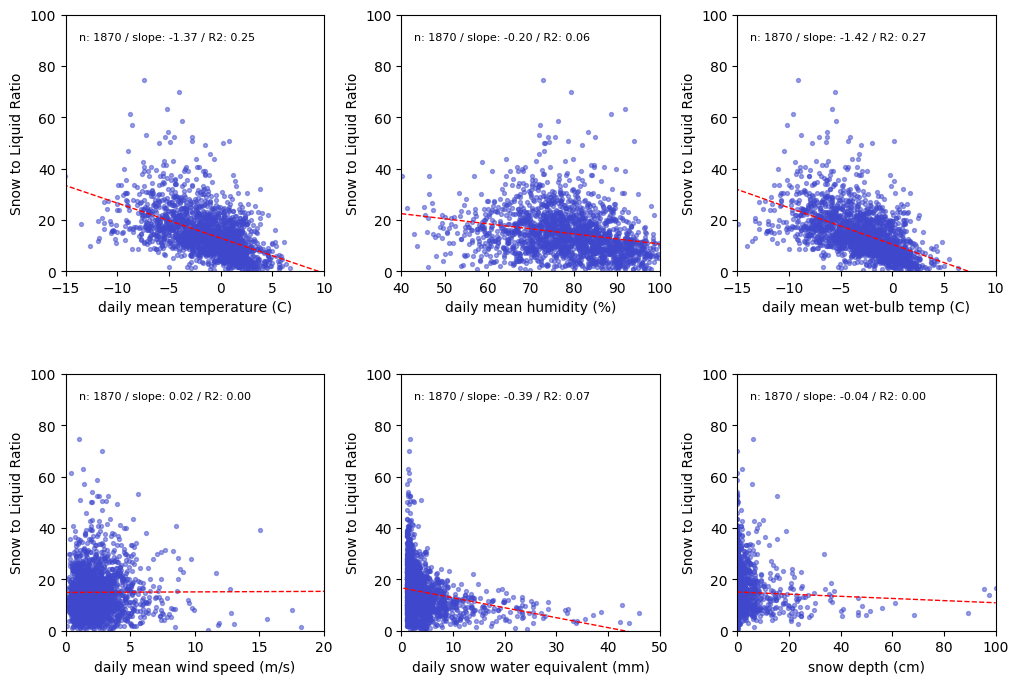

In [3]:
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

nrow, ncol = 2, 3
fig, ax = plt.subplots(nrow, ncol, figsize = (12,8))
plt.subplots_adjust(hspace=0.4, wspace=0.3)

ymax = 100
ylim = (0, ymax)
color = "#3F48CC"

subset = df.copy()

pred_list = ['ta_avg','hm_avg','tw_avg','ws_avg','swe','sd_min']

for index, pred in enumerate(pred_list):
    if pred == "ta_avg":
        pred_name = "daily mean temperature (C)"
        xmax = 20
        xlim = (-15,10)
    elif pred == "tw_avg":
        pred_name = "daily mean wet-bulb temp (C)"
        xmax = 20
        xlim = (-15,10)
    elif pred == "hm_avg":
        pred_name = "daily mean humidity (%)"
        xmax = 100
        xlim = (40,100)
    elif pred == "ws_avg":
        pred_name = "daily mean wind speed (m/s)"
        xmax = 100
        xlim = (0,20)
    elif pred == "swe":
        pred_name = "daily snow water equivalent (mm)"
        xmax = 50
        xlim = (0,50)
    elif pred == "sd_min":
        pred_name = "snow depth (cm)"
        xmax = 100
        xlim = (0,100)

    i, j = index//ncol, index%ncol
    ax[i,j].set_xlabel(pred_name)
    ax[i,j].set_ylabel('Snow to Liquid Ratio')
    ax[i,j].set_ylim(ylim)
    ax[i,j].set_xlim(xlim)

    X = subset[[pred]]
    Y = subset['slr']
    model = LinearRegression()
    model.fit(X, Y)

    subset['regress'] = model.predict(X)
    r2 = r2_score(subset['slr'], subset['regress'])
    slope = model.coef_[0]
    n = len(subset['slr'])

    ax[i,j].plot([-xmax,xmax], model.predict(pd.DataFrame([-xmax,xmax], columns=[pred])), linewidth=1, color='red', linestyle="--")
    ax[i,j].text(xlim[0]+(xlim[1]-xlim[0])/20,ymax*0.9,'n: {n} / slope: {slope:.2f} / R2: {r2:.2f}'.format(n=n, slope=slope, r2=r2), fontsize=8, color="black")
    ax[i,j].scatter(subset[pred], subset['slr'], color=color, s=8, alpha=0.5)

plt.show()

**3. Multi-variate linear regression (t-test)**  


In [ ]:
from scipy import stats

cutoff_date = pd.Timestamp('2024-04-30')
trainset = df[df['date'] <= cutoff_date].dropna().copy()

varname = ['ta_avg','hm_avg','tw_avg','ws_avg','swe','sd_min']

X = trainset[varname]
Y = trainset['slr']

model = LinearRegression()
model.fit(X, Y)

# Calculate degrees of freedom (n - k - 1)
n = X.shape[0]   # Number of observations
k = X.shape[1]   # Number of predictors
dfd = n - k - 1   # Degrees of freedom

# Calculate Mean Squared Error
trainset['regress'] = model.predict(X)
trainset['residual'] = trainset['slr'] - trainset['regress']
mse = np.sum(trainset['residual']**2) / dfd

# Calculate standard errors of coefficients
X_with_intercept = np.c_[np.ones(X.shape[0]), X]  # Add intercept column
var_b = mse * np.linalg.inv(X_with_intercept.T @ X_with_intercept).diagonal()
std_err = np.sqrt(var_b)

# Calculate t-statistics for each coefficient
std_err = std_err[1:]
t_stats = model.coef_ / std_err  # Exclude intercept error

# Calculate the p-values for each coefficient
p_values = [2 * (1 - stats.t.cdf(np.abs(t), dfd)) for t in t_stats]

# append t-test results
df_stats = pd.DataFrame()
columns = ["variable", "coeff", "t_stats", "std_err", "p_value", "significance"]

for i in range(len(p_values)):
    rows = []
    indicies = []

    df_series = {}
    df_series["variable"] = varname[i]
    df_series["coeff"] = model.coef_[i]
    df_series["t_stats"] = t_stats[i]
    df_series["std_err"] = std_err[i]
    df_series["p_value"] = p_values[i]
    if p_values[i] < 0.001:
        sig_code = "***"
    elif p_values[i] < 0.01:
        sig_code = "**"
    elif p_values[i] < 0.05:
        sig_code = "*"
    else:
        sig_code = ""

    df_series["significance"] = sig_code

    for index in columns:
        rows.append(df_series[index])
        indicies.append(index)

    df_stats = pd.concat([df_stats, pd.DataFrame([rows], columns=indicies)], ignore_index=True)

print(df_stats)

  variable     coeff   t_stats   std_err       p_value significance
0   ta_avg  5.083870  4.739364  1.072690  2.358547e-06          ***
1   hm_avg  0.352473  4.814878  0.073205  1.630018e-06          ***
2   tw_avg -6.789086 -5.965332  1.138090  3.075891e-09          ***
3   ws_avg  0.151861  1.307216  0.116171  1.913506e-01             
4      swe -0.253384 -7.405945  0.034214  2.222666e-13          ***
5   sd_min -0.090740 -3.664845  0.024759  2.565821e-04          ***


**3-1. Fitting again (to avoid collinearity)**  

In [ ]:
varname = ['tw_avg', 'swe', 'sd_min']
X = trainset[varname]
Y = trainset['slr']

model = LinearRegression()
model.fit(X, Y)

LinearRegression()

**3-2. Evaluate the linear regression model using a validation set**  

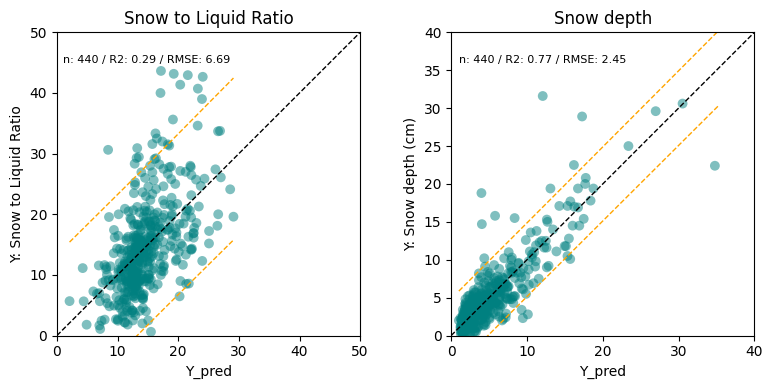

In [ ]:
import seaborn as sns

# Evaluate the model with validation set
validset = df[df['date'] > cutoff_date].dropna().copy()

varname = ['tw_avg', 'swe', 'sd_min']
X = validset[varname]

# Calculate degrees of freedom (n - k - 1)
n = X.shape[0]   # Number of observations
k = X.shape[1]   # Number of predictors
dfd = n - k - 1   # Degrees of freedom
p = 2  # One slope + one intercept

# Calculate Mean Squared Error
validset['regress'] = model.predict(X)
validset['residual'] = validset['slr'] - validset['regress']
mse = np.sum(validset['residual']**2) / dfd

validset['sd_regress'] = validset['regress'] * validset['swe'] / 10
validset['sd_residual'] = validset['sd_day_max'] - validset['sd_regress']
sd_mse = np.sum(validset['sd_residual']**2) / dfd

# Standard error of predictions
X_with_intercept = np.column_stack((np.ones(len(X)), X))  # Add intercept
pred_se = np.sqrt(np.diag(mse * (1 + X_with_intercept @ np.linalg.inv(X_with_intercept.T @ X_with_intercept) @ X_with_intercept.T)))
sd_pred_se = np.sqrt(np.diag(sd_mse * (1 + X_with_intercept @ np.linalg.inv(X_with_intercept.T @ X_with_intercept) @ X_with_intercept.T)))

# Prediction Interval (95%)
confidence_level = 0.95
t_value = stats.t.ppf((1 + confidence_level) / 2, n - p)
validset['prediction_interval_lower'] = validset['regress'] - t_value * pred_se
validset['prediction_interval_upper'] = validset['regress'] + t_value * pred_se

validset['sd_prediction_interval_lower'] = validset['sd_regress'] - t_value * sd_pred_se
validset['sd_prediction_interval_upper'] = validset['sd_regress'] + t_value * sd_pred_se

# Plot the results
fig, ax = plt.subplots(1,2, figsize=(9,4))
plt.subplots_adjust(hspace=0.4, wspace=0.3)

# Plot SLR
ax[0].set_aspect("equal")
ymax = 50

ax[0].plot([0,ymax], [0,ymax], linewidth=1, color="black", linestyle="--")
color = "#008080"

r2 = r2_score(validset['slr'], validset['regress'])
rmse = np.sqrt(mean_squared_error(validset['regress'], validset['slr']))
n = len(validset['slr'])
ax[0].text(1,ymax*0.9,'n: {n} / R2: {R2:.2f} / RMSE: {RMSE:.2f}'.format(n=n, R2=r2, RMSE=rmse), fontsize=8, color="black")
sns.regplot(x=validset['regress'], y=validset['prediction_interval_lower'], lowess=True, scatter_kws={'s':0}, line_kws={'color':'orange', 'linewidth':1, 'linestyle':'--'}, ax=ax[0])
sns.regplot(x=validset['regress'], y=validset['prediction_interval_upper'], lowess=True, scatter_kws={'s':0}, line_kws={'color':'orange', 'linewidth':1, 'linestyle':'--'}, ax=ax[0])
ax[0].scatter(validset['regress'], validset['slr'], color=color, alpha=0.5, edgecolors='none', s=50)

ax[0].set_ylim(0,ymax)
ax[0].set_xlim(0,ymax)
ax[0].set_xlabel('Y_pred')
ax[0].set_ylabel('Y: Snow to Liquid Ratio')
ax[0].set_title('Snow to Liquid Ratio')

# Plot snow-depth
ax[1].set_aspect("equal")
ymax = 40

ax[1].plot([0,ymax], [0,ymax], linewidth=1, color="black", linestyle="--")
color = "#008080"

r2 = r2_score(validset['sd_day_max'], validset['sd_regress'])
rmse = np.sqrt(mean_squared_error(validset['sd_day_max'], validset['sd_regress']))
n = len(validset['sd_day_max'])
ax[1].text(1,ymax*0.9,'n: {n} / R2: {R2:.2f} / RMSE: {RMSE:.2f}'.format(n=n, R2=r2, RMSE=rmse), fontsize=8, color="black")
sns.regplot(x=validset['sd_regress'], y=validset['sd_prediction_interval_lower'], lowess=True, scatter_kws={'s':0}, line_kws={'color':'orange', 'linewidth':1, 'linestyle':'--'}, ax=ax[1])
sns.regplot(x=validset['sd_regress'], y=validset['sd_prediction_interval_upper'], lowess=True, scatter_kws={'s':0}, line_kws={'color':'orange', 'linewidth':1, 'linestyle':'--'}, ax=ax[1])
ax[1].scatter(validset['sd_regress'], validset['sd_day_max'], color=color, alpha=0.5, edgecolors='none', s=50)

ax[1].set_ylim(0,ymax)
ax[1].set_xlim(0,ymax)
ax[1].set_xlabel('Y_pred')
ax[1].set_ylabel('Y: Snow depth (cm)')
ax[1].set_title('Snow depth')

plt.show()

**4-1. Set the regional information**  

In [ ]:
reg_info = [{"reg_name":"전남권", "fct_key": "11F2%:21F2%"},
            {"reg_name":"전북", "fct_key": "11F1%:21F1%"},
            {"reg_name":"강원내륙", "fct_key": "11D1%"},
            {"reg_name":"강원산지,경북북동산지", "fct_key": "11D201%:11D202%:11D203%:11H108%"},
            {"reg_name":"강원동해안,경북북부동해안", "fct_key": "11D204%:11D205%:11D206%:11H101%"},
            {"reg_name":"경북북부내륙", "fct_key": "11H103%:11H104%:11H105%"},
            {"reg_name":"수도권", "fct_key": "11B1%:11B2%", },
            {"reg_name":"충남권", "fct_key": "11C2%", },
            {"reg_name":"충북", "fct_key": "11C1%"}]

**4-2. Draw box-plots of Snow to Liquid Ratio and Wet-bulb Temp for each regions**

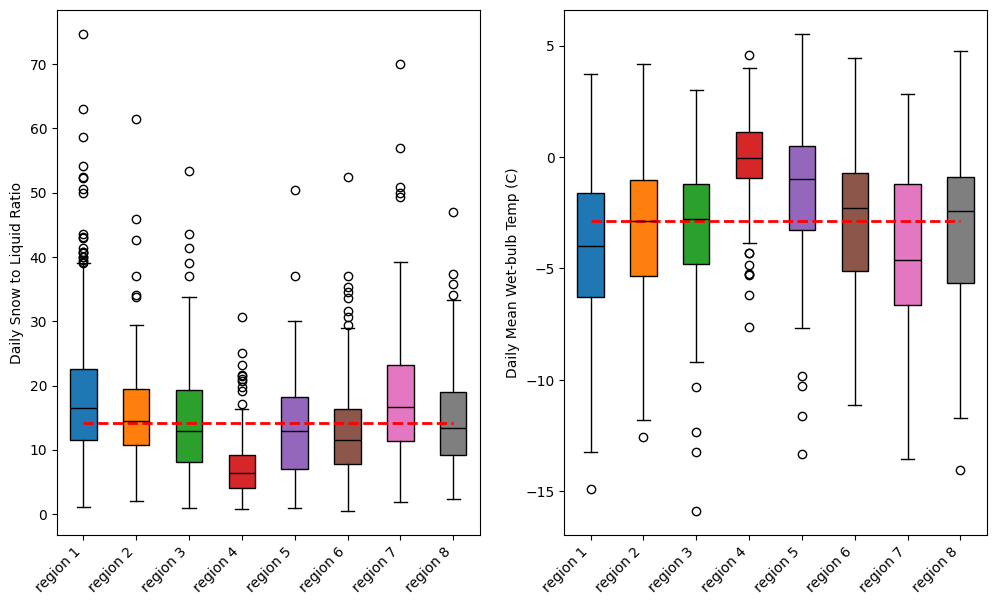

In [ ]:
from matplotlib.patches import Patch

data_label = []
data_slr = []
data_tw = []
df_reg = pd.DataFrame()

for index, reg in enumerate(reg_info):
    keys = [el[:-1] for el in reg["fct_key"].split(":")]
    subset = df[df['fct_id'].str.contains("|".join(keys), na=False)].dropna().copy()
    df_reg = pd.concat([df_reg, subset], ignore_index=True)
    data_slr.append(subset['slr'])
    data_tw.append(subset['tw_avg'])
    data_label.append("region " + str(index+1))

# Box-plots
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f']
nrow, ncol = 1, 2
fig, ax = plt.subplots(nrow, ncol, figsize=(12,7))
box = ax[0].boxplot(data_slr, showfliers=True, patch_artist=True, boxprops=dict(zorder=1))
ax[0].plot(range(1, len(data_slr)+1), [np.median(df_reg["slr"]) for d in range(1, len(data_slr)+1)], color='red', linewidth=2, linestyle='dashed', zorder=2)
ax[0].set_ylabel('Daily Snow to Liquid Ratio')
ax[0].set_xticks(np.arange(len(data_label))+1)
ax[0].set_xticklabels(data_label, rotation=45, ha='right')

for patch, color in zip(box['boxes'], colors):
    patch.set_facecolor(color)

for median in box['medians']:
    median.set_color('black')

box = ax[1].boxplot(data_tw, showfliers=True, patch_artist=True, boxprops=dict(zorder=1))
ax[1].plot(range(1, len(data_tw)+1), [np.median(df_reg["tw_avg"]) for d in range(1, len(data_slr)+1)], color='red', linewidth=2, linestyle='dashed', zorder=2)
ax[1].set_ylabel('Daily Mean Wet-bulb Temp (C)')
ax[1].set_xticks(np.arange(len(data_label))+1)
ax[1].set_xticklabels(data_label, rotation=45, ha='right')

for patch, color in zip(box['boxes'], colors):
    patch.set_facecolor(color)

for median in box['medians']:
    median.set_color('black')

plt.subplots_adjust(top=0.95)
plt.subplots_adjust(bottom=0.2)
plt.show()

**5-1. Fit a Mixed Linear Model**  

In [ ]:
from statsmodels.formula.api import mixedlm
import statsmodels.api as sm

for i, reg in enumerate(reg_info):
    keys = [el[:-1] for el in reg["fct_key"].split(":")]
    index = df[df['fct_id'].str.contains("|".join(keys), na=False)].index
    df.loc[index,"reg"] = "region " + str(i+1)

subset = df.dropna().copy()

# Fit a mixed linear model
model_full = mixedlm("slr ~ tw_avg + sd_min + swe", subset, groups=subset["reg"]).fit(method="powell")
print(model_full.summary())

# Random effects
print('Random Effects')
print(model_full.random_effects)

# Variance ratio
model_reduced = sm.OLS.from_formula("slr ~ tw_avg + sd_min + swe", data=subset).fit()
variance_ratio = model_full.cov_re/(model_full.cov_re+model_full.scale)
variance_ratio = variance_ratio["Group"].Group
print('')
print('Random effect variance')
print(model_full.cov_re)

print('')
print('Residual  variance')
print(model_full.scale)

print('')
print('Variance ratio')
print(variance_ratio)

         Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: slr       
No. Observations: 1653    Method:             REML      
No. Groups:       8       Scale:              58.8826   
Min. group size:  91      Log-Likelihood:     -5727.0701
Max. group size:  553     Converged:          Yes       
Mean group size:  206.6                                 
--------------------------------------------------------
             Coef.  Std.Err.    z    P>|z| [0.025 0.975]
--------------------------------------------------------
Intercept    12.540    0.648  19.360 0.000 11.270 13.809
tw_avg       -1.220    0.060 -20.360 0.000 -1.337 -1.102
sd_min       -0.089    0.029  -3.090 0.002 -0.145 -0.032
swe          -0.292    0.036  -8.174 0.000 -0.362 -0.222
Group Var     2.470    0.196                            

Random Effects
{'region 1': Group    1.810847
dtype: float64, 'region 2': Group   -0.005634
dtype: float64, 'region 3': Group    1.747857
dtype: float64, 

**5-2. Log-likelihood test based on parametric bootstrapping**  

Since the variance ratio of the random effects to the residual is small, parametric bootstrapping provides more accurate estimates than non-parametric bootstrapping.

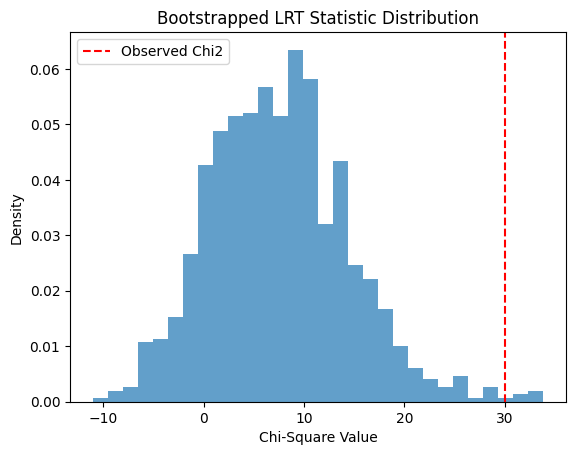

p-value: 0.003000


In [ ]:
from scipy.stats import chi2
from sklearn.utils import resample
from numpy.random import normal

ll_full = model_full.llf  # Log-likelihood of the full model
ll_reduced = model_reduced.llf  # Log-likelihood of the reduced model

observed_lr_stat = -2 * (ll_reduced - ll_full)

# Bootstrapping the Null Distribution
n_bootstraps = 1000
bootstrap_lr_stats = []

for _ in range(n_bootstraps):
    # Simulate y values using model prediction + noise
    noise = normal(scale=np.sqrt(model_reduced.mse_resid), size=len(subset))

    # Replace y values in data
    data_bootstrap = subset.copy()
    data_bootstrap["noise"] = noise
    data_bootstrap["new_slr"] = data_bootstrap["slr"] + noise

    # Fit models on resampled data
    try:
        model_full_boot = mixedlm("new_slr ~ tw_avg + sd_min + swe", data_bootstrap, groups=data_bootstrap["reg"]).fit(method="powell")
        model_reduced_boot = sm.OLS.from_formula("new_slr ~ tw_avg + sd_min + swe", data=data_bootstrap).fit()

        # Compute likelihood ratio statistic for bootstrap sample
        ll_full_boot = model_full_boot.llf
        ll_reduced_boot = model_reduced_boot.llf
        bootstrap_lr_stat = -2 * (ll_reduced_boot - ll_full_boot)
        bootstrap_lr_stats.append(bootstrap_lr_stat)
    except:
        pass  # Ignore failed fits (rare but possible)

# Compute Empirical p-value
bootstrap_lr_stats = np.array(bootstrap_lr_stats)
p_value_empirical = np.mean(bootstrap_lr_stats >= observed_lr_stat)

# Plot Bootstrapped LRT Statistics
plt.hist(bootstrap_lr_stats, bins=30, alpha=0.7, density=True)
plt.axvline(30, color='red', linestyle='dashed', label="Observed Chi2")
plt.legend()
plt.title("Bootstrapped LRT Statistic Distribution")
plt.xlabel("Chi-Square Value")
plt.ylabel("Density")
plt.show()

p_value_empirical = np.mean(bootstrap_lr_stats >= observed_lr_stat)
print(f"p-value: {p_value_empirical:.6f}")